In [7]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

import math
from sklearn.preprocessing import MinMaxScaler
import pywt
from scipy.signal import medfilt

In [8]:
def denoise(data):
    #小波变换
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

In [9]:
ours = pd.read_csv("data.csv", header=None)
ours = ours.iloc[1:, :]
ours = ours.T
ours

,1,2,3,4,5,6,7,8,9,10,...,243569,243570,243571,243572,243573,243574,243575,243576,243577,243578
0,-2358.0,-2232.0,-2205.0,-2232.0,-2201.0,-2076.0,-2004.0,-2105.0,-2328.0,-2459.0,...,-408.0,-330.0,-315.0,-343.0,-375.0,-345.0,-262.0,-189.0,-208.0,-294.0
1,2645.0,2661.0,2553.0,2459.0,2474.0,2578.0,2667.0,2707.0,2733.0,2755.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2183.0,1986.0,1719.0,1634.0,1724.0,1760.0,1590.0,1291.0,1124.0,1237.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1218.0,1094.0,845.0,780.0,952.0,1128.0,1063.0,844.0,706.0,762.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,230.0,123.0,150.0,268.0,410.0,463.0,330.0,34.0,-279.0,-421.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1808.0,1630.0,1453.0,1382.0,1477.0,1697.0,1907.0,1903.0,1655.0,1387.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1863.0,1502.0,1435.0,1636.0,1811.0,1697.0,1352.0,1094.0,1192.0,1576.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-2049.0,-1764.0,-1585.0,-1721.0,-2015.0,-2172.0,-2083.0,-1902.0,-1805.0,-1851.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# normalization
def norm(X):
    for i in range(X.shape[0]):
        row = X[i, :]
        X[i, :] = (row - row.min())/(row.max()-row.min())
    return

In [110]:
def downsample(data, prehz, newhz):
    time = int(len(data)/prehz)  # 时间长度s
    st = float(prehz)/float(newhz)
    new_series = []
    for i in range(0, time):
        pre_series = data[i*prehz:(i+1)*prehz-1]  # 每1秒的数据
        temp = []         # 存放新1s的数据
        temp.append(pre_series[0])
        for j in range(1, newhz - 1):
            index = round(j * st)
            temp.append(data[index])
        temp.append(pre_series[-1])
        new_series.append(temp)
    return new_series

In [133]:
def hz_convert(array):
    new_array = []
    for i in range(0, len(array)):
        each = array[i]
        each = downsample(each, 948, 370)
        new_array.append(np.array(each).flatten())
    return new_array

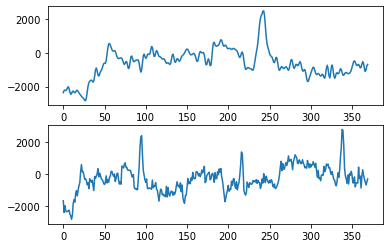

In [12]:
from scipy import signal

ss = ours.iloc[0, :]
s = ss.dropna()
s = [i for i in s if i<=10000 and i>=-10000]
# plt.plot(s)
s = s[0: len(s) - len(s)%25] 
plt.subplot(2, 1, 1)
plt.plot(s[0:370])
down_signal = signal.resample(s, int(len(s)/2.56))
plt.subplot(2, 1, 2)
plt.plot(down_signal[0:370])

In [134]:
def read_our_data(data):
    our_data = []
        
    for i in range(data.shape[0]):
        s = data.iloc[i, :]
        s = s.dropna()
        

        s = [i for i in s if math.isnan(i) == False]
        
        # median filter
        filt = int(512*0.8)
        mf = medfilt(s, filt) #中值濾波
        s_filted = (s - mf)[int(len(s)*0.05):-int(len(s)*0.05)]
        
        # splicing data into 948
        for i in range(0,len(s_filted), 948):
            if i + 948 >= len(s_filted):
                break
            tmp = s_filted[i:i+948]
            if max(tmp)<8000 and min(tmp)>-8000:
                our_data.append(tmp)
                
    # wavelet transform
    signal_denoise = denoise(our_data)
        
    our_down = hz_convert(signal_denoise)
            
    our_data = np.array(our_down)

    return our_data

<h2> Read our data and merged into normal dataset

In [135]:
our_data = read_our_data(ours)

In [136]:
our_data.shape

(1145, 370)

In [77]:
covid = pd.read_csv('D:/school\大三專題/paper_covid/covid/lead1+3/Covid_lead I.csv', header=None)
normal = pd.read_csv('D:/school/大三專題/paper_covid/normal/lead1+3/Normal_lead I.csv', header=None)
covid = np.array(covid.T)
normal = np.array(normal.T)

In [137]:
from sklearn.model_selection import train_test_split
normal_dataset_train, normal_dataset_test = train_test_split(normal, train_size=0.8, shuffle=True)
our_data_train, our_data_test = train_test_split(our_data, train_size=0.8, shuffle=True)

<h2> Split COVID and NORMAL data for training data & test data

In [138]:
normal_X_train = np.concatenate((normal_dataset_train, our_data_train))
normal_X_train = np.concatenate((normal_X_train, -our_data_train))
normal_X_test = np.concatenate((normal_dataset_test, our_data_test))
covid_X_train, covid_X_test = train_test_split(covid, train_size=0.8, shuffle=True)

In [139]:
norm(normal_X_train)
norm(normal_X_test)
norm(covid_X_train)
norm(covid_X_test)

In [140]:
for i in range(200):
    noise = 0.05 * np.random.normal(0, 0.1, 370);
    noisySignal = covid_X_train[i] + noise;
    covid_X_train = np.vstack([covid_X_train, noisySignal])
    
    noise2 = 0.05 * np.random.normal(0, 0.2, 370);
    noisySignal2 = covid_X_train[i] + noise2;
    covid_X_train = np.vstack([covid_X_train, noisySignal2])
    
    noise3 = 0.05 * np.random.normal(0, 0.3, 370);
    noisySignal3 = covid_X_train[i] + noise3;
    covid_X_train = np.vstack([covid_X_train, noisySignal3])

In [141]:
normal_X_train.shape, covid_X_train.shape

((1992, 370), (800, 370))

In [142]:
# for i in range(160):
#     noise = 0.05 * np.random.normal(0, 0.1, 370);
#     noisySignal = covid_X_train[i] + noise;
#     covid_X_train = np.vstack([covid_X_train, noisySignal])
    
#     noise2 = 0.05 * np.random.normal(0, 0.2, 370);
#     noisySignal2 = covid_X_train[i] + noise2;
#     covid_X_train = np.vstack([covid_X_train, noisySignal2])
    
#     noise3 = 0.05 * np.random.normal(0, 0.3, 370);
#     noisySignal3 = covid_X_train[i] + noise3;
#     covid_X_train = np.vstack([covid_X_train, noisySignal3])

In [143]:
normal_Y_train = np.zeros(len(normal_X_train))
normal_Y_test = np.zeros(len(normal_X_test))
covid_Y_train = np.ones(len(covid_X_train))
covid_Y_test = np.ones(len(covid_X_test))

In [144]:
X_train = np.concatenate((normal_X_train, covid_X_train))
Y_train = np.concatenate((normal_Y_train, covid_Y_train))
X_test = np.concatenate((normal_X_test, covid_X_test))
Y_test = np.concatenate((normal_Y_test, covid_Y_test))

<h2> make X_data type to 0 ~ 255

In [145]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        X_train[i][j] = min(255, int(X_train[i][j]*255))
        
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        X_test[i][j] = min(255, int(X_test[i][j]*255))       

<h2> Get testsamples on board ( 0~ 255 without minus 128 ).

In [146]:
# X_test_board = np.concatenate((X_test[0:25], X_test[6673:6673+25]))
# Y_test_board = np.concatenate((np.zeros(25), np.ones(25)))

<h2> make data to -128 ~ 127

In [147]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        X_train[i][j] = X_train[i][j] - 128
        
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        X_test[i][j] = X_test[i][j] - 128

<h2> Suffle

In [148]:
import random
def shuffle_array(X, Y):
    shuffle_index= np.arange(X.shape[0])
    random.shuffle(shuffle_index)
    shuffle_X = X[shuffle_index]
    shuffle_Y = Y[shuffle_index]
    return shuffle_X, shuffle_Y

In [149]:
X_train, Y_train = shuffle_array(X_train, Y_train)

In [150]:
from tensorflow.python.keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train, 2)
Y_test = np_utils.to_categorical(Y_test, 2)
print(Y_train.shape, Y_test.shape)

(2792, 2) (319, 2)


<h2> CNN model

In [151]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1],1,1)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1],1,1)

In [152]:
X_test_reshaped.shape, X_train_reshaped.shape

((319, 370, 1, 1), (2792, 370, 1, 1))

In [153]:
# X_test_reshaped = X_test_reshaped.astype(np.uint8)
# X_train_reshaped = X_train_reshaped.astype(np.uint8)

In [164]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint


keras.backend.clear_session()

def build_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3,1), padding='same', activation='relu', input_shape=(370, 1,1)))
    model.add(MaxPooling2D(pool_size=(3,1)))
    model.add(Conv2D(filters=24, kernel_size=(3,1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,1)))
    model.add(Flatten())
    model.add(Dense(8, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model()

In [165]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 370, 1, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 123, 1, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 123, 1, 24)        1176      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 1, 24)         0         
_________________________________________________________________
flatten (Flatten)            (None, 984)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 7880      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [166]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_function = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.000000001)
callbacks_list = [learning_rate_function]
history = model.fit(X_train_reshaped[:800], Y_train, epochs=100, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/100
20/20 [==============================] - 0s 13ms/step - loss: 3.2311 - accuracy: 0.5797 - val_loss: 0.8065 - val_accuracy: 0.6750
Epoch 2/100
20/20 [==============================] - 0s 17ms/step - loss: 0.6891 - accuracy: 0.6750 - val_loss: 0.5387 - val_accuracy: 0.6750
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 0.5214 - accuracy: 0.6750 - val_loss: 0.5267 - val_accuracy: 0.6875
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5119 - accuracy: 0.6859 - val_loss: 0.5140 - val_accuracy: 0.6875
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5016 - accuracy: 0.6844 - val_loss: 0.5006 - val_accuracy: 0.6875
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4926 - accuracy: 0.6859 - val_loss: 0.5026 - val_accuracy: 0.7000
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4815 - accuracy: 0.6859 - val_loss: 0.4939 - val_accuracy: 0.7063
Epoch 8/100

Epoch 52/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.1063 - val_accuracy: 0.9750
Epoch 53/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.1064 - val_accuracy: 0.9750
Epoch 54/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.1066 - val_accuracy: 0.9750
Epoch 55/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.1067 - val_accuracy: 0.9750
Epoch 56/100
 1/20 [>.............................] - ETA: 0s - loss: 0.0220 - accuracy: 1.0000
Epoch 00056: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
20/20 [==============================] - 0s 3ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.1068 - val_accuracy: 0.9750
Epoch 57/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.1069 - val_ac

20/20 [==============================] - 0s 3ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.1072 - val_accuracy: 0.9750
Epoch 100/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.1072 - val_accuracy: 0.9750


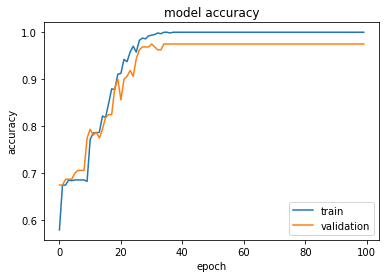

In [167]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

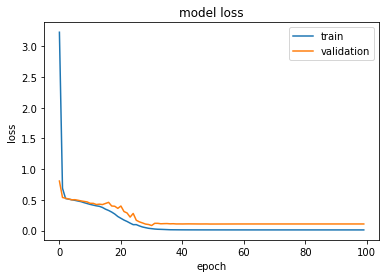

In [168]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [169]:
keras.backend.clear_session()
model2 = model
[loss, acc] = model2.evaluate(X_test_reshaped, Y_test, verbose=1)

10/10 [==============================] - 0s 5ms/step - loss: 0.2326 - accuracy: 0.9185


In [170]:
prediction = model2.predict(X_test_reshaped)
classes = np.argmax(prediction, axis=1)
classes

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,

In [171]:
X_test_reshaped.shape

(319, 370, 1, 1)

In [172]:
ans = [int(i) for i in Y_test[:, 1]]

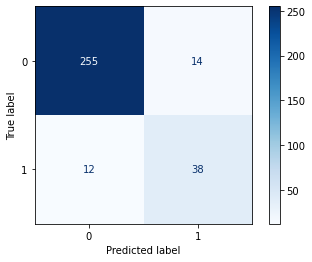

In [173]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(ans, classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

<h1> converted to tflite

In [38]:
model2.save('model_save')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_save\assets


In [39]:
model_test = keras.models.load_model('model_save')

# Model Evaluation
score = model_test.evaluate(X_test_reshaped, Y_test, verbose = 0)
print('test loss', score[0])
print('accuracy', score[1])

test loss 0.11365614086389542
accuracy 0.9855491518974304


## Quantization

In [40]:
model = model_test

In [41]:
# tensorflow lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\陳奕帆\AppData\Local\Temp\tmpkk19mvy0\assets


In [42]:
train_data = tf.cast(X_test_reshaped, tf.float32)
# train_data = X_train_reshaped
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_data).batch(1).take(100):
    # Model has only one input so each data point has one element.
        yield [input_value]

In [43]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_data_gen

tflite_model_quant_int8 = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\陳奕帆\AppData\Local\Temp\tmpg3uaca5w\assets


INFO:tensorflow:Assets written to: C:\Users\陳奕帆\AppData\Local\Temp\tmpg3uaca5w\assets


In [44]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


In [45]:
import pathlib

tflite_models_dir = pathlib.Path("generated/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_quant_file_int8 = tflite_models_dir/"tflite_model_quant_int8_c.tflite"
tflite_model_quant_file_int8.write_bytes(tflite_model_quant_int8)

14608

## Evaluate TensorFlow Lite Quant (int8) Model

In [46]:
def evaluate_model(interpreter, X_test, Y_test):
#     X_test_data = tf.cast(X_test, tf.float32)

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    scale, zero_point = interpreter.get_input_details()[0]['quantization']

    prediction_values = []
    
    i=0
    for test_data in X_test:
#         print('Processing '+str(i)+' data');
        # Pre-processing: add batch dimension, quantize and convert inputs to int8 to match with
        # the model's input data format.
        test_data = np.expand_dims(test_data, axis=0)#.astype(interpreter.get_input_details()[0]["dtype"])
        test_data = np.int8(test_data / scale + zero_point)
        interpreter.set_tensor(input_index, test_data)

        interpreter.invoke()

        # Find the letter with highest probability
        output = interpreter.tensor(output_index)
#         print(output())
        result = np.argmax(output()[0])
        prediction_values.append(result)
        i = i + 1
    
    print(prediction_values)
    accurate_count = 0
    for index in range(len(prediction_values)):
        if prediction_values[index] == Y_test[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_values)

    return accuracy * 100

In [47]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file_int8))
interpreter.allocate_tensors()

print(str(evaluate_model(interpreter, X_test_reshaped, Y_test[:,1])) + "%")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 

<h2> Transfer test data to Cpp

In [48]:
# X_test_board.shape, Y_test_board.shape

In [49]:
# samples_file = open("generated/test_samples_c.cpp", "w")

# samples_file.write("#include \"test_samples.h\"\n\n")
# samples_file.write("const int kNumSamples = " + str(48) + ";\n\n")

# samples = "" 
# samples_array = "const TestSample_c test_samples_c[kNumSamples] = {"

# for index in range(48):
#     data_arr = list(np.ndarray.flatten(X_test_board[index]))
#     data_arr = [int(i) for i in data_arr]
#     var_name = "sample" + str(index+1) + "c"
#     samples += "TestSample_c " + var_name + " = {\n" #+ "[IMAGE_SIZE] = { "
#     samples += "\t.label = " + str(int(Y_test_board[index])) + ",\n" 
#     samples += "\t.image = {\n"
#     wrapped_arr = [data_arr[i:i + 10] for i in range(0, len(data_arr), 10)]
#     for sub_arr in wrapped_arr:
#         samples += "\t\t" + str(sub_arr)
#     samples += "\t}\n};\n\n"    
#     samples_array += var_name + ", "
    
# samples = samples.replace("[", "")
# samples = samples.replace("]", ",\n")
# samples_array += "};\n"

# samples_file.write(samples);
# samples_file.write(samples_array);
# samples_file.close()

In [50]:
# samples_file = open("generated/test_samples_2.cpp", "w")

# samples_file.write("#include \"test_samples.h\"\n\n")
# samples_file.write("const int kNumSamples = " + str(X_test_reshaped.shape[0]) + ";\n\n")

# samples = "" 
# samples_array = "const TestSample_c test_samples_c[kNumSamples] = {"

# for index in range(X_test_reshaped.shape[0]):
#     data_arr = list(np.ndarray.flatten(X_test_reshaped[index]))
#     data_arr = [int(i) for i in data_arr]
#     var_name = "sample" + str(index+1)
#     samples += "TestSample_c " + var_name + " = {\n" #+ "[IMAGE_SIZE] = { "
#     samples += "\t.label = " + str(int(Y_test[index,1])) + ",\n" 
#     samples += "\t.image = {\n"
#     wrapped_arr = [data_arr[i:i + 10] for i in range(0, len(data_arr), 10)]
#     for sub_arr in wrapped_arr:
#         samples += "\t\t" + str(sub_arr)
#     samples += "\t}\n};\n\n"    
#     samples_array += var_name + ", "
    
# samples = samples.replace("[", "")
# samples = samples.replace("]", ",\n")
# samples_array += "};\n"

# samples_file.write(samples);
# samples_file.write(samples_array);
# samples_file.close()

<h2>元中的數據

In [51]:
yu = pd.read_csv('./dataset/test_data.txt', header=None)
yu = yu.T.to_numpy().reshape(-1)

In [52]:
yu = yu[-370:]

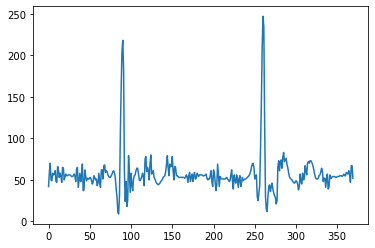

In [53]:
plot_yu = yu.reshape(-1)
plt.plot(plot_yu)

In [54]:
yu = yu.reshape(1, 370, 1, 1)

In [55]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file_int8))
interpreter.allocate_tensors()

print(str(evaluate_model(interpreter, yu, [0])) + "%")

[1]
0.0%
